# Hermes Reply Challenge — Fase 5

Notebook de Machine Learning com dados simulados de sensores.

In [136]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import joblib
import os

In [137]:
def simulate_sensor_series(sensor_id, start_ts, n, base, sigma, anomaly_prob=0.02, anomaly_magnitude=3.0):
    timestamps = [start_ts + timedelta(seconds=i*60) for i in range(n)]
    values = np.random.normal(loc=base, scale=sigma, size=n)
    labels = np.zeros(n, dtype=int)
    for i in range(n):
        if random.random() < anomaly_prob:
            values[i] += np.random.normal(loc=0, scale=sigma*anomaly_magnitude)
            labels[i] = 1
    df = pd.DataFrame({
        'sensor_id': sensor_id,
        'timestamp': timestamps,
        'value': values,
        'label': labels
    })
    return df

In [138]:
n_readings = 800
start = datetime.now() - timedelta(days=1)

s1 = simulate_sensor_series(sensor_id=1, start_ts=start, n=n_readings, base=50.0, sigma=0.5, anomaly_prob=0.03)
s2 = simulate_sensor_series(sensor_id=2, start_ts=start, n=n_readings, base=5.0, sigma=1.0, anomaly_prob=0.02)
s3 = simulate_sensor_series(sensor_id=3, start_ts=start, n=n_readings, base=10.0, sigma=0.8, anomaly_prob=0.015)

df_all = s1.merge(s2[['timestamp','value','label']], on='timestamp', suffixes=('_s1','_s2'))
df_all = df_all.merge(s3[['timestamp','value','label']], on='timestamp')
df_all.rename(columns={'value':'value_s3','label':'label_s3'}, inplace=True)
df_all['label_any'] = ((df_all['label_s1']==1) | (df_all['label_s2']==1) | (df_all['label_s3']==1)).astype(int)

df_all['v1'] = df_all['value_s1']
df_all['v2'] = df_all['value_s2']
df_all['v3'] = df_all['value_s3']
df_all['r1_mean_3'] = df_all['v1'].rolling(window=3, min_periods=1).mean()
df_all['r2_mean_3'] = df_all['v2'].rolling(window=3, min_periods=1).mean()
df_all['r3_mean_3'] = df_all['v3'].rolling(window=3, min_periods=1).mean()

features = ['v1','v2','v3','r1_mean_3','r2_mean_3','r3_mean_3']
X = df_all[features].fillna(method='bfill').fillna(0)
y = df_all['label_any']

print('Dataset shape:', X.shape)
print('Distribuição de labels:', y.value_counts())

Dataset shape: (800, 6)
Distribuição de labels: label_any
0    748
1     52
Name: count, dtype: int64


C:\Users\victo\AppData\Local\Temp\ipykernel_11440\3204746143.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df_all[features].fillna(method='bfill').fillna(0)


In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
cm

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       187
           1       0.00      0.00      0.00        13

    accuracy                           0.93       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.87      0.93      0.90       200



array([[186,   1],
       [ 13,   0]])

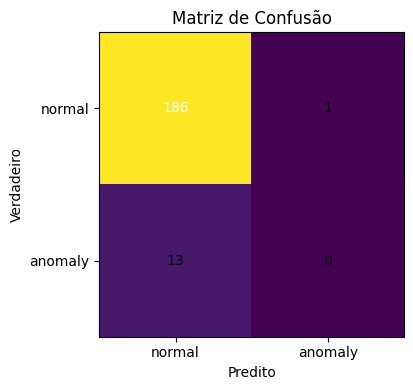

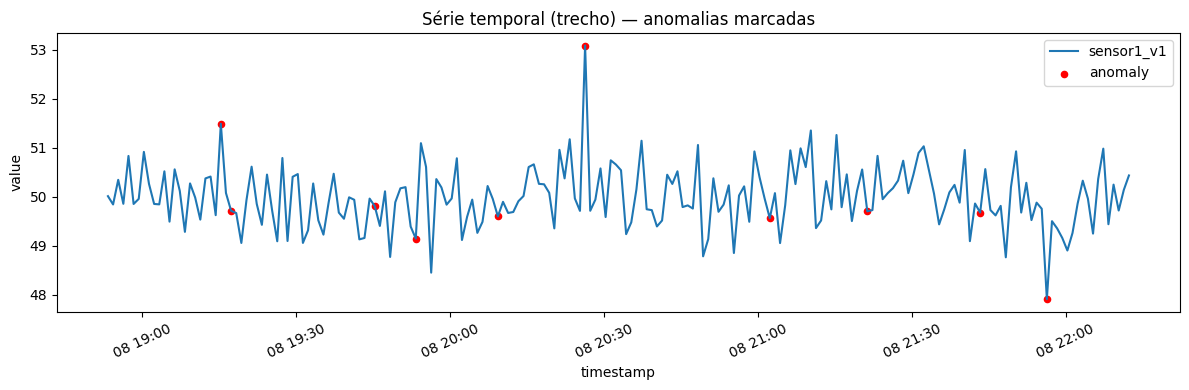

In [140]:
# Matriz de confusão
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Predito')
ax.set_ylabel('Verdadeiro')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['normal','anomaly']); ax.set_yticklabels(['normal','anomaly'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

# Série temporal com anomalias
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_all['timestamp'][:200], df_all['v1'][:200], label='sensor1_v1')
ax.scatter(df_all['timestamp'][:200][df_all['label_any'][:200]==1],
           df_all['v1'][:200][df_all['label_any'][:200]==1],
           color='red', label='anomaly', s=20)
ax.set_xlabel('timestamp'); ax.set_ylabel('value')
ax.set_title('Série temporal (trecho) — anomalias marcadas')
ax.legend()
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()